# Notebook for Data Science Final Project: Trying to make a model to predict the rating of a video game in the steam dataset

## Authors: Stuart Harley, Kyle Rodrigues, Matt Haas

In [ ]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics

#### Load Dataset / Adjust Features

In [ ]:
# sometimes steam.csv works, other times it is /steam.csv
df = pd.read_csv("steam.csv")

In [ ]:
# Creating a release_month column taking the month value from the release_date column.
df['release_month'] = pd.DatetimeIndex(df['release_date']).month

In [ ]:
# this would be our output/ response variable
df["rating"] = df["positive_ratings"] / (df["positive_ratings"] + df["negative_ratings"]) * 100

For the sake of this analysis, we will be removing some features that we don't want to use for our analysis. We also need to change the datatypes for some of the features.

In [ ]:
# For developer and publisher, there are too many unique values to make it a usable categorical variable ~15k each
# I think we would have to categorize each game developer as small/medium/large or something but that would take a lot of work
df = df.drop('appid', 1)
df = df.drop('release_date', 1)
df = df.drop('developer', 1)
df = df.drop('publisher', 1)
df = df[df.owners != '0-20000']
df.reset_index(inplace=True,drop=True)

In [ ]:
# converting relevant columns to categorical variables
df["owners"] = df["owners"].astype('category')
df["required_age"] = df["required_age"].astype('category')
df["categories"] = df["categories"].astype('category')
df["genres"] = df["genres"].astype('category')
df["steamspy_tags"] = df["steamspy_tags"].astype('category') # there does seem to be overlap between this column and genres
df["platforms"] = df["platforms"].astype('category')
df["release_month"] = df["release_month"].astype('category')
df["english"] = df["english"].astype('category')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8479 entries, 0 to 8478
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   name              8479 non-null   object  
 1   english           8479 non-null   category
 2   platforms         8479 non-null   category
 3   required_age      8479 non-null   category
 4   categories        8479 non-null   category
 5   genres            8479 non-null   category
 6   steamspy_tags     8479 non-null   category
 7   achievements      8479 non-null   int64   
 8   positive_ratings  8479 non-null   int64   
 9   negative_ratings  8479 non-null   int64   
 10  average_playtime  8479 non-null   int64   
 11  median_playtime   8479 non-null   int64   
 12  owners            8479 non-null   category
 13  price             8479 non-null   float64 
 14  release_month     8479 non-null   category
 15  rating            8479 non-null   float64 
dtypes: category(8), float64(

using p-value of 0.01
#### Linear Regression Tests

| Variable Name | p-value  | pearson | statistically significant |
|---------------|----------|---|------------------------|
| average_playtime       | 0.00073     | 0.036 | yes                        |
| median_playtime      | 0.04 | 0.022 | no                       |
| price       | 1.45e-45 | 0.15 | yes                       |
| achievements | 0.018 | -0.026 | yes |

In [ ]:
headers = ["average_playtime", "median_playtime", "price", "achievements"]

for name in headers:
    _, _, _, p, _ = stats.linregress(df["rating"], df[name])
    r, _ = stats.pearsonr(df["rating"], df[name])
    print(name, "versus rating: p-value =", p, "\npearson correlation coefficient =", r, "\n")

average_playtime versus rating: p-value = 0.0007377162599912958 
pearson correlation coefficient = 0.03664719505209066 

median_playtime versus rating: p-value = 0.039691263231792596 
pearson correlation coefficient = 0.02233884729939114 

price versus rating: p-value = 1.5625976957597286e-45 
pearson correlation coefficient = 0.15292149182807477 

achievements versus rating: p-value = 0.01817846203729662 
pearson correlation coefficient = -0.025650352052030274 



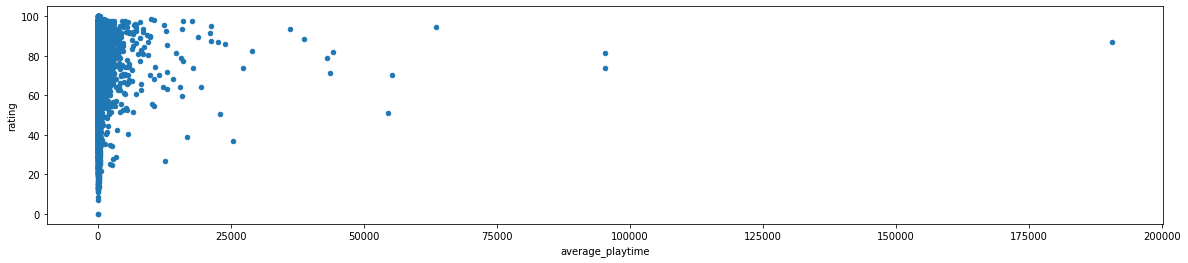

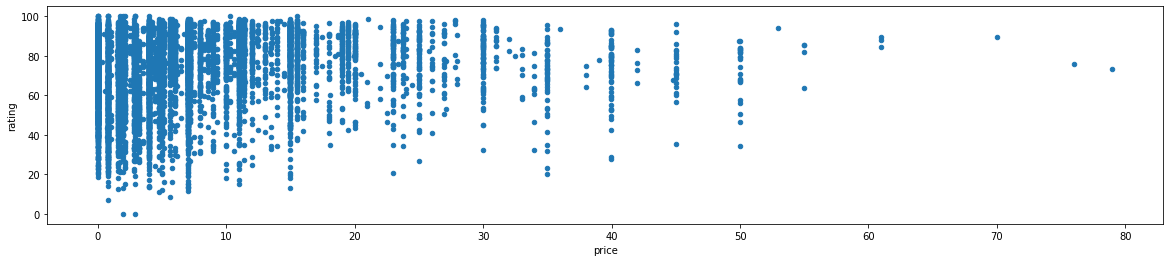

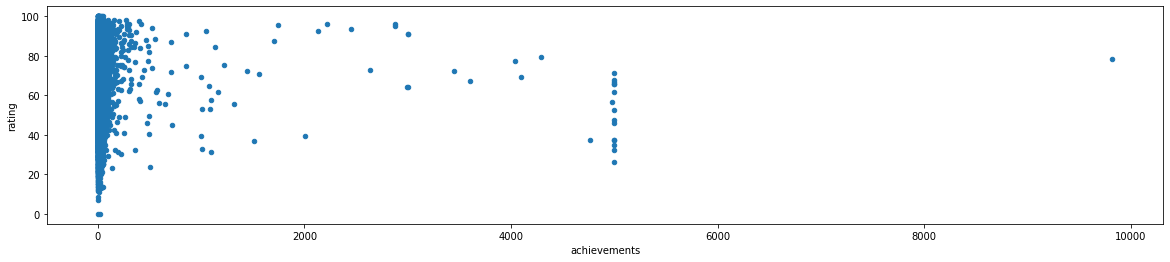

In [ ]:
# Plotting scatter plots of the predictive numerical variables
df.plot.scatter(x='average_playtime', y='rating', figsize=(20,4))
df.plot.scatter(x='price', y='rating', figsize=(20,4));
df.plot.scatter(x='achievements', y='rating', figsize=(20,4));

using p-value of 0.01
#### Kruskal-Wallis Tests

| Variable Name | p-value  | statistically significant |
|---------------|----------|---------------------------|
| required age | .006 | yes |
| owners       | 1.44e-62 | yes                       |
| platforms       | 3.43e-81 | yes                       |
| release_month | 0.036 | yes |
| english | .29 | no |

In [ ]:
headers = ["required_age", "owners", "platforms", "release_month", "english"]

for name in headers:
    samples_by_group = []
    for value in set(df[name]):
        mask = df[name] == value
        samples_by_group.append(df["rating"][mask])
    stat, p = stats.kruskal(*samples_by_group)
    print(name, "versus rating: p-value =", p)

required_age versus rating: p-value = 0.006196189364389729
owners versus rating: p-value = 1.4453473612126944e-62
platforms versus rating: p-value = 3.423304406077233e-81
release_month versus rating: p-value = 0.03622843060491119
english versus rating: p-value = 0.2926425829733527


#### Graphical Testing

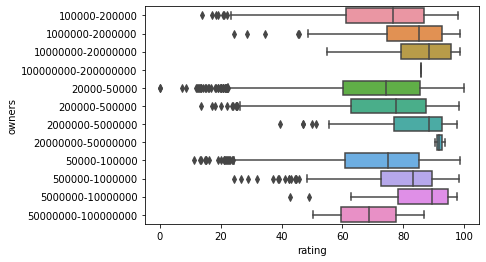

In [ ]:
# Plotting boxplots of the predictive categorical variables
sns.boxplot(x='rating', y='owners', data=df);

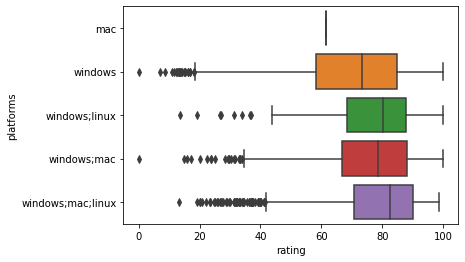

In [ ]:
sns.boxplot(x='rating', y='platforms', data=df);

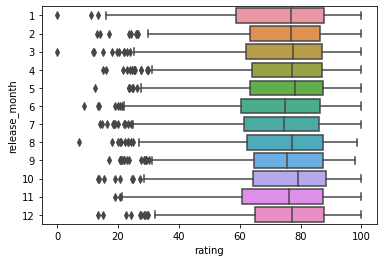

In [ ]:
# Based off the boxplot, I would say month really isn't that predictive even tho it had a stat. sig. p-value
sns.boxplot(x='rating', y='release_month', data=df);

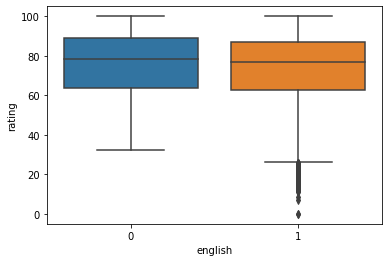

In [ ]:
sns.boxplot(x='english', y='rating', data=df);

#### One Hot Encode Features

Attempt to deal with the categorical variables with a one hot encoded matrix is below.

In [ ]:
def oneHotEncodedDfFromNumberSeries(name, prefix):
  return pd.get_dummies(df[name], prefix=prefix)

# takes series with values like Action;Adventure;Horror and makes a one hot encoded df with columns Action, Adventure, and Horror
def oneHotEncodedDfFromStringSeries(name, prefix):
  # split on ; and get dummies from resulting matrix
  new_df = pd.get_dummies(df[name].str.split(';', expand=True), prefix=prefix)
  # above results in duplicated column names create set of expected column names
  column_names = list(set(new_df.columns))
  # group by expected columns names
  new_df = new_df.groupby(column_names, level=0, axis=1).max()
  return new_df

In [ ]:
# Takes the feature name, iterates through column and extracts unique values
def oneHotEncodingSplit(name):
    # Create set to avoid having duplicate values
    features = set([])

    # Iterate through feature
    for x in range(len(df[name])):
        # Add the values found from spliting the string to features
        features.update(df[name][x].split(';'))
    return list(features)

# Will one hot encode a feature
def oneHotEncodingAggegate(name):
    # Get unique list of features from the feature column
    features = oneHotEncodingSplit(name)
    # Create empty 2d array to hold our one hot encoding
    features_values = np.zeros((len(df[name]), len(features)), dtype=int)
    
    # Iterate through full feature and update rows in features_values
    for x in range(len(df[name])):
        # Split values from feature
        vals = df[name][x].split(';')
        
        # Add values to features_values
        for v in range(len(vals)):
            col = features.index(vals[v])
            features_values[x][col] = 1
    
    # Adjust name and add to features
    name += ":"
    features = [name + feature for feature in features]
    
    # Add data and columns to dataframe
    new_df = pd.DataFrame(data=features_values, columns=features)
    return new_df

In [ ]:
genre_df = oneHotEncodingAggegate("genres")
cat_df = oneHotEncodingAggegate("categories")
owner_df = oneHotEncodedDfFromStringSeries("owners", "owner")
age_df = oneHotEncodedDfFromNumberSeries("required_age", "age")
tag_df = oneHotEncodingAggegate("steamspy_tags")
platform_df = oneHotEncodingAggegate("platforms")

# will want to add positive/neg ratings, price, etc.
new_df = pd.concat([genre_df, cat_df, owner_df, age_df, tag_df], axis=1)
new_df

,genres:Photo Editing,genres:Gore,genres:Sports,genres:Strategy,genres:Action,genres:Video Production,genres:Sexual Content,genres:Accounting,genres:Early Access,genres:Simulation,genres:Violent,genres:Nudity,genres:Free to Play,genres:Adventure,genres:Indie,genres:Audio Production,genres:Web Publishing,genres:Education,genres:Racing,genres:RPG,genres:Casual,genres:Design & Illustration,genres:Software Training,genres:Massively Multiplayer,genres:Utilities,genres:Animation & Modeling,genres:Game Development,categories:Steam Cloud,categories:Cross-Platform Multiplayer,categories:Local Co-op,categories:Steam Turn Notifications,categories:Single-player,categories:Steam Achievements,categories:Mods (require HL2),categories:Partial Controller Support,categories:Steam Leaderboards,categories:Valve Anti-Cheat enabled,categories:Steam Workshop,categories:MMO,categories:Includes level editor,...,steamspy_tags:Crime,steamspy_tags:3D Platformer,steamspy_tags:Relaxing,steamspy_tags:Abstract,steamspy_tags:Word Game,steamspy_tags:Rogue-lite,steamspy_tags:Real Time Tactics,steamspy_tags:Base-Building,steamspy_tags:Otome,steamspy_tags:Hockey,steamspy_tags:Dark Fantasy,steamspy_tags:Third Person,steamspy_tags:Bullet Hell,steamspy_tags:RPG,steamspy_tags:Multiplayer,steamspy_tags:Replay Value,steamspy_tags:Exploration,steamspy_tags:Casual,steamspy_tags:Rhythm,steamspy_tags:Illuminati,steamspy_tags:Skating,steamspy_tags:Noir,steamspy_tags:Isometric,steamspy_tags:Flight,steamspy_tags:Crafting,steamspy_tags:PvP,steamspy_tags:Real-Time with Pause,steamspy_tags:Detective,steamspy_tags:Voice Control,steamspy_tags:Sokoban,steamspy_tags:Lemmings,steamspy_tags:1980s,steamspy_tags:Dungeon Crawler,steamspy_tags:Beautiful,steamspy_tags:Military,steamspy_tags:Psychedelic,steamspy_tags:Board Game,steamspy_tags:Time Management,steamspy_tags:2D Fighter,steamspy_tags:Gun Customization
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8474,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8475,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8476,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8477,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Visualization to help understand dataset and highly rated games

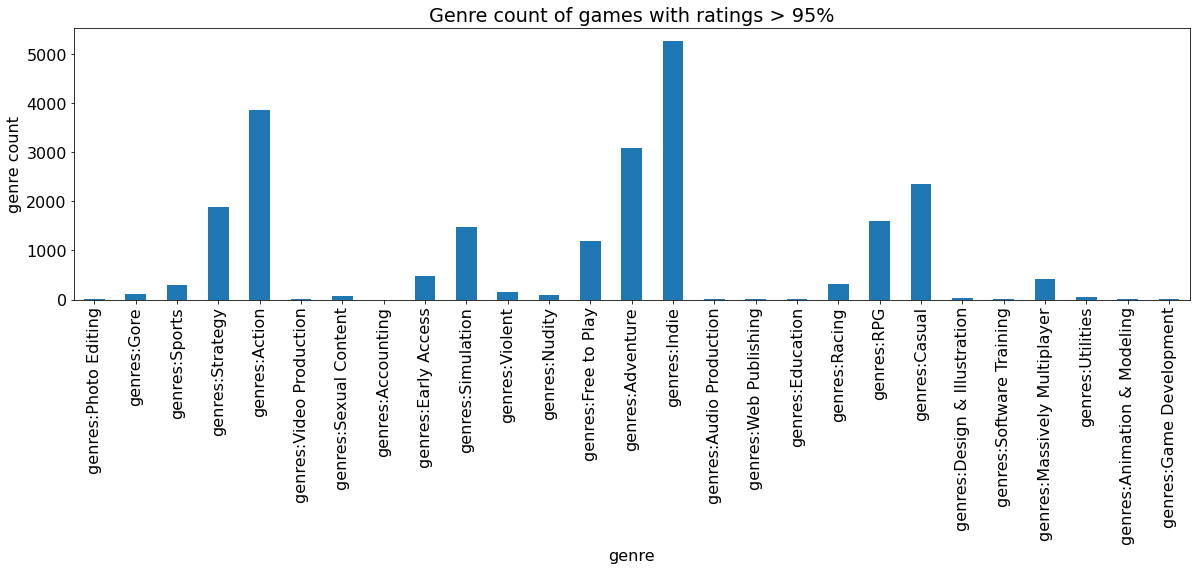

In [ ]:
# print out most popular genres for games with rating > 95%
mask = df['rating'] > .95
popular_genre_count = genre_df[mask].sum()
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(20,5))
plt.xlabel('genre')
plt.ylabel('genre count')
plt.title('Genre count of games with ratings > 95%')
popular_genre_count.plot(kind='bar')

#### Statistic

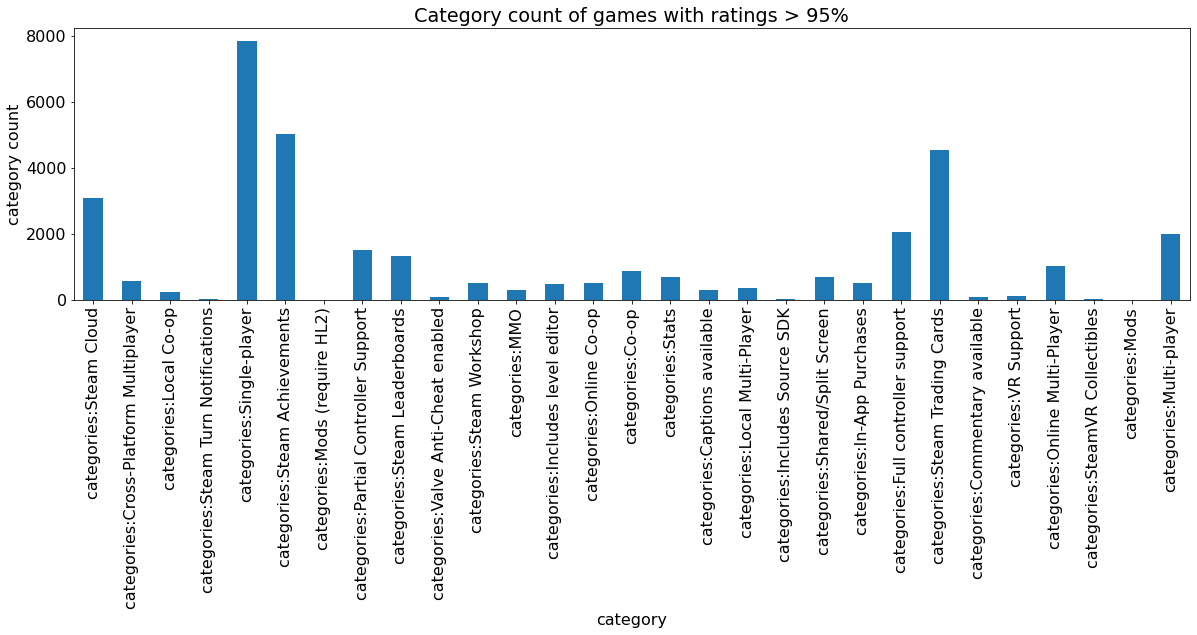

In [ ]:
# print out most popular genres for games with rating > 95%
mask = df['rating'] > .95
popular_cat_count = cat_df[mask].sum()
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(20,5))
plt.xlabel('category')
plt.ylabel('category count')
plt.title('Category count of games with ratings > 95%')
popular_cat_count.plot(kind='bar')

using p-value of 0.01
#### Kruskal-Wallis Tests for platforms

| Variable Name | p-value  | pearson | statistically significant |
|---------------|----------|--|-------------------------|
| platforms:mac | 4.02e-73 | 0.195 | yes |
| platforms:linux | 1.74e-67 | 0.18 | yes |
| platforms:windows | .362 | -0.007 | no |

In [ ]:
stat_df = pd.concat([df, platform_df], axis=1)
headers = ["platforms:mac", "platforms:linux", "platforms:windows"]

for name in headers:
    samples_by_group = []
    for value in set(stat_df[name]):
        mask = stat_df[name] == value
        samples_by_group.append(df["rating"][mask])
    stat, p = stats.kruskal(*samples_by_group)
    r, _ = stats.pearsonr(df["rating"], platform_df[name])
    print(name, "versus rating: p-value =", p, "\npearson: ", r)

platforms:mac versus rating: p-value = 4.0209896511727516e-73 
pearson:  0.19578234276346462
platforms:linux versus rating: p-value = 1.7442968945923128e-67 
pearson:  0.1807311188054108
platforms:windows versus rating: p-value = 0.3618290561071478 
pearson:  0.007114600318711102


using p-value of 0.01
#### Genres Kruskal-Wallis Tests - Only putting in statistically sig genre features

| Variable Name | p-value  | pearson | statistically significant |
|---------------|----------|--|---------------------------|
| genres:Violent | .00079 | -0.033 | yes |
| genres:Simulation | 9.9e-.08 | -0.06 | yes |
| genres:Strategy | 2.06e-.07 | -0.04 | yes |
| genres:Racing | 8.51e-05 | -0.041 | yes |
| genres:Gore | 0.001 | -0.37 | yes |
| genres:Indie | .0002 | 0.037 | yes |
| genres:Sports | .003 | -0.03 | yes |
| genres:Massively Multiplayer | 7.04e-43 | -0.125 | yes |
| genres:Free to Play | 5.95e-14 | -0.66 | yes |

In [ ]:
stat_df = pd.concat([df, genre_df], axis=1)
headers = genre_df.columns

for name in headers:
    samples_by_group = []
    for value in set(stat_df[name]):
        mask = stat_df[name] == value
        samples_by_group.append(df["rating"][mask])
    stat, p = stats.kruskal(*samples_by_group)
    r, _ = stats.pearsonr(df["rating"], genre_df[name])
    print(name, "versus rating: p-value =", p, "\npearson: ", r)

genres:Photo Editing versus rating: p-value = 0.1344361752449218 
pearson:  -0.012219759617410661
genres:Gore versus rating: p-value = 0.001168953820943914 
pearson:  -0.03790714674885067
genres:Sports versus rating: p-value = 0.0030753163621015755 
pearson:  -0.02633962370111069
genres:Strategy versus rating: p-value = 2.061917867187756e-07 
pearson:  -0.03998742939091457
genres:Action versus rating: p-value = 0.003051268195935146 
pearson:  -0.034115112363700434
genres:Video Production versus rating: p-value = 0.2409848362422249 
pearson:  0.014166267842428013
genres:Sexual Content versus rating: p-value = 0.0031057333570609297 
pearson:  0.035336389761007926
genres:Accounting versus rating: p-value = 0.8357447037613519 
pearson:  0.0004955369109837277
genres:Early Access versus rating: p-value = 2.487096539888663e-05 
pearson:  -0.0402936161073502
genres:Simulation versus rating: p-value = 9.900199114359023e-08 
pearson:  -0.05727312536584341
genres:Violent versus rating: p-value = 

using p-value of 0.01
#### Category Kruskal-Wallis Tests - Only putting in statistically sig category features

| Variable Name | p-value  | pearson | statistically significant |
|---------------|----------|--|---------------------------|
| categories:In-App Purchases | 3.68e-39 | -.117 | yes |
| categories:SteamVR Collectibles | 4.04e-06 | .045 | yes |
| categories:Single-player | 7.00e-30 | .108 | yes |
| categories:Steam Workshop | 1.64e-22 | .104 | yes |
| categories:Includes level editor | 6.35e-15 | .081 | yes |
| categories:Full controller support | 4.32e-55 | .168 | yes |
| categories:Multi-player | 9.37e-10 | -.043 | yes |
| categories:Captions available | 2.26e-08 | .058 | yes |
| categories:Shared/Split Screen | 3.65e-08 | .058 | yes |
| categories:Steam Leaderboards | 6.37e-22 | .114 | yes |
| categories:Local Multi-Player | 1.22e-05 | .044 | yes |
| categories:Steam Cloud | 8.70e-108 | .236 | yes |
| categories:Local Co-op | 8.96e-12 | .069 | yes |
| categories:Steam Achievements | 2.03e-55 | .181 | yes |
| categories:MMO | 6.83e-35 | -.111 | yes |
| categories:Online Multi-Player | 8.54e-12 | -.048 | yes |

In [ ]:
stat_df = pd.concat([df, cat_df], axis=1)
headers = cat_df.columns

for name in headers:
    samples_by_group = []
    for value in set(stat_df[name]):
        mask = stat_df[name] == value
        samples_by_group.append(df["rating"][mask])
    stat, p = stats.kruskal(*samples_by_group)
    r, _ = stats.pearsonr(df["rating"], cat_df[name])
    print(name, "versus rating: p-value =", p, "\npearson: ", r)

categories:Steam Cloud versus rating: p-value = 8.69811656379754e-108 
pearson:  0.23593000346471402
categories:Cross-Platform Multiplayer versus rating: p-value = 0.06154858153768373 
pearson:  -0.0028724723950129746
categories:Local Co-op versus rating: p-value = 8.961094687725238e-12 
pearson:  0.06917960025977163
categories:Steam Turn Notifications versus rating: p-value = 0.9403174731766056 
pearson:  0.007238240079729603
categories:Single-player versus rating: p-value = 6.999625025669635e-30 
pearson:  0.10812286660950102
categories:Steam Achievements versus rating: p-value = 2.0324323370268004e-55 
pearson:  0.18067096429853804
categories:Mods (require HL2) versus rating: p-value = 0.4865778832419174 
pearson:  0.007444645023252949
categories:Partial Controller Support versus rating: p-value = 0.377922489346026 
pearson:  0.00041110186826776626
categories:Steam Leaderboards versus rating: p-value = 6.374488132303549e-22 
pearson:  0.11415335050295485
categories:Valve Anti-Cheat 

#### Tags statistical testing (too many tags for a table)

In [ ]:
stat_df = pd.concat([df, tag_df], axis=1)
headers = tag_df.columns

for name in headers:
    samples_by_group = []
    for value in set(stat_df[name]):
        mask = stat_df[name] == value
        samples_by_group.append(df["rating"][mask])
    stat, p = stats.kruskal(*samples_by_group)
    r, _ = stats.pearsonr(df["rating"], tag_df[name])
    if p < 0.01:
      print(name, "versus rating: p-value =", p, "\npearson: ", r) # Printed out only the ones with stat sig values below

steamspy_tags:Action versus rating: p-value = 3.01021737476843e-19 
pearson:  -0.0967626972714711
steamspy_tags:Adventure versus rating: p-value = 0.0002237883867324203 
pearson:  -0.03702907855082436
steamspy_tags:Story Rich versus rating: p-value = 3.9918394160324927e-19 
pearson:  0.08563967380613872
steamspy_tags:Survival Horror versus rating: p-value = 0.0004246261940407429 
pearson:  0.036767431944494014
steamspy_tags:Post-apocalyptic versus rating: p-value = 0.009598144678803303 
pearson:  0.03012905722936082
steamspy_tags:MMORPG versus rating: p-value = 2.74384271766446e-05 
pearson:  -0.04126677706473756
steamspy_tags:Co-op versus rating: p-value = 5.87895962828063e-07 
pearson:  0.051342964749699044
steamspy_tags:Nudity versus rating: p-value = 1.74682438499845e-08 
pearson:  0.056855784780179885
steamspy_tags:Difficult versus rating: p-value = 1.256623475815541e-08 
pearson:  0.05460763034228783
steamspy_tags:1990's versus rating: p-value = 0.009696754180735952 
pearson:  0.

#### Applying Models

#### Experiment 1 (combined significant categorical and numeric variables)

Result: Combined performed the best of all our experiments but the difference was negligible.

In [ ]:
# Combining the one-hot encoding matrix and the other predictive features into one df
# Predictive features: english, achievements, average_playtime, price, platforms(mac & linux), age, owner, genre(some), category(some), steamspy_tag(some)

pred_df = pd.concat([df[['name', 'english', 'achievements', 'average_playtime', 'price']], platform_df[['platforms:linux', 'platforms:mac']], age_df, owner_df,
                     genre_df[['genres:Violent', 'genres:Simulation', 'genres:Strategy', 'genres:Racing', 'genres:Gore', 'genres:Indie', 'genres:Sports',
                               'genres:Massively Multiplayer', 'genres:Free to Play']],
                     cat_df[['categories:In-App Purchases', 'categories:SteamVR Collectibles', 'categories:Single-player', 'categories:Steam Workshop',
                             'categories:Includes level editor', 'categories:Full controller support', 'categories:Multi-player',
                             'categories:Captions available', 'categories:Shared/Split Screen', 'categories:Steam Leaderboards', 'categories:Local Multi-Player',
                             'categories:Steam Cloud', 'categories:Local Co-op', 'categories:Steam Achievements', 'categories:MMO',
                             'categories:Online Multi-Player']],
                     tag_df[['steamspy_tags:Hidden Object', 'steamspy_tags:Racing', 'steamspy_tags:Classic', 'steamspy_tags:Sports', 'steamspy_tags:Survival',
                             'steamspy_tags:Story Rich', 'steamspy_tags:Atmospheric', 'steamspy_tags:Difficult', 'steamspy_tags:Indie', 'steamspy_tags:Cute',
                             'steamspy_tags:Violent', 'steamspy_tags:Platformer', 'steamspy_tags:Pixel Graphics', 'steamspy_tags:Comedy', 'steamspy_tags:Visual Novel',
                             'steamspy_tags:Strategy', 'steamspy_tags:Simulation', 'steamspy_tags:Great Soundtrack', 'steamspy_tags:Massively Multiplayer',
                             'steamspy_tags:Point & Click', 'steamspy_tags:Action', 'steamspy_tags:Free to Play', 'steamspy_tags:Anime', 'steamspy_tags:Co-op',
                             'steamspy_tags:Choices Matter', 'steamspy_tags:Twin Stick Shooter', 'steamspy_tags:Local Multiplayer', 'steamspy_tags:Puzzle',
                             'steamspy_tags:Bullet Hell', 'steamspy_tags:Shoot \'Em Up']], df['rating']], axis=1);

In [ ]:
pred_df.head()

,name,english,achievements,average_playtime,price,platforms:linux,platforms:mac,age_0,age_3,age_7,age_12,age_16,age_18,owner_100000-200000,owner_1000000-2000000,owner_10000000-20000000,owner_100000000-200000000,owner_20000-50000,owner_200000-500000,owner_2000000-5000000,owner_20000000-50000000,owner_50000-100000,owner_500000-1000000,owner_5000000-10000000,owner_50000000-100000000,genres:Violent,genres:Simulation,genres:Strategy,genres:Racing,genres:Gore,genres:Indie,genres:Sports,genres:Massively Multiplayer,genres:Free to Play,categories:In-App Purchases,categories:SteamVR Collectibles,categories:Single-player,categories:Steam Workshop,categories:Includes level editor,categories:Full controller support,...,categories:Captions available,categories:Shared/Split Screen,categories:Steam Leaderboards,categories:Local Multi-Player,categories:Steam Cloud,categories:Local Co-op,categories:Steam Achievements,categories:MMO,categories:Online Multi-Player,steamspy_tags:Hidden Object,steamspy_tags:Racing,steamspy_tags:Classic,steamspy_tags:Sports,steamspy_tags:Survival,steamspy_tags:Story Rich,steamspy_tags:Atmospheric,steamspy_tags:Difficult,steamspy_tags:Indie,steamspy_tags:Cute,steamspy_tags:Violent,steamspy_tags:Platformer,steamspy_tags:Pixel Graphics,steamspy_tags:Comedy,steamspy_tags:Visual Novel,steamspy_tags:Strategy,steamspy_tags:Simulation,steamspy_tags:Great Soundtrack,steamspy_tags:Massively Multiplayer,steamspy_tags:Point & Click,steamspy_tags:Action,steamspy_tags:Free to Play,steamspy_tags:Anime,steamspy_tags:Co-op,steamspy_tags:Choices Matter,steamspy_tags:Twin Stick Shooter,steamspy_tags:Local Multiplayer,steamspy_tags:Puzzle,steamspy_tags:Bullet Hell,steamspy_tags:Shoot 'Em Up,rating
0,Counter-Strike,1,0,17612,7.19,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,97.388815
1,Team Fortress Classic,1,0,277,3.99,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,83.978740
2,Day of Defeat,1,0,187,3.99,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,89.564761
3,Deathmatch Classic,1,0,258,3.99,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,82.662338
4,Half-Life: Opposing Force,1,0,624,3.99,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,94.799567


In [ ]:
# Scaling and train/test splitting
X = pred_df.drop(['name', 'rating'], axis=1).to_numpy()
Y = pred_df['rating'].to_numpy()
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.30)

# Linear Regression
regr = LinearRegression()
regr.fit(X_train, y_train)
pred = regr.predict(X_test)
print("Linear Regression")
print("Mean Squared Error: " + str(metrics.mean_squared_error(y_test, pred)))
print("Mean Absolute Error: " + str(metrics.mean_absolute_error(y_test, pred)) + "\n")

# Support Vector Machine - Takes significantly longer than the other 2 models ~ 1min
svm = SVR()
svm.fit(X_train, y_train)
pred = svm.predict(X_test)
print("SVM")
print("Mean Squared Error: " + str(metrics.mean_squared_error(y_test, pred)))
print("Mean Absolute Error: " + str(metrics.mean_absolute_error(y_test, pred)) + "\n")

# Random Forest
rf = RandomForestRegressor(n_estimators=100, bootstrap = True, max_features = 'sqrt')
rf.fit(X_train, y_train)
pred = rf.predict(X_test)
print("Random Forest")
print("Mean Squared Error: " + str(metrics.mean_squared_error(y_test, pred)))
print("Mean Absolute Error: " + str(metrics.mean_absolute_error(y_test, pred)))

Linear Regression
Mean Squared Error: 3.240753223855792e+28
Mean Absolute Error: 3569146934813.7153

SVM
Mean Squared Error: 268.9283221306796
Mean Absolute Error: 12.455787963120661

Random Forest
Mean Squared Error: 246.6030884218192
Mean Absolute Error: 12.275283247729556


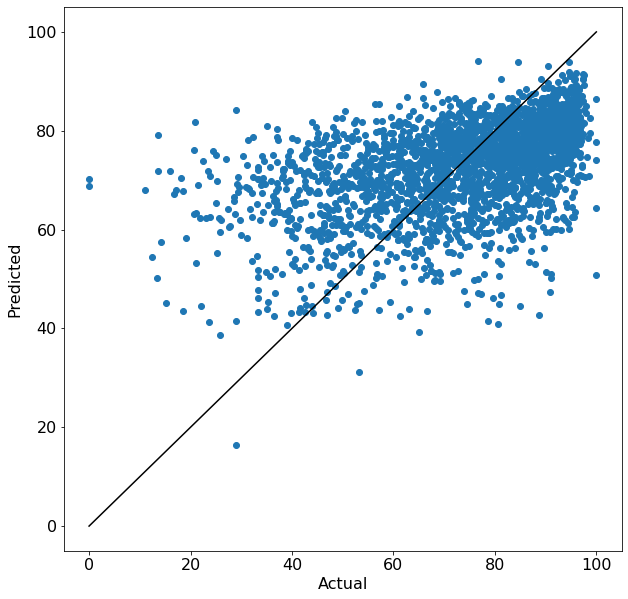

In [ ]:
fig, axes = plt.subplots(figsize=(10,10))
axes.scatter(y_test, pred) # Only plotting 1/4 of points because it gets dense
axes.set_xlabel('Actual')
axes.set_ylabel('Predicted')
axes.plot([0, 100], [0,100], c='k');

### Experiment 2 - All predictive features that would be known at publishing time of a game. This would allow us to predict the rating of a game before anyone downloads it.

In [ ]:
# not including average_playtime, achievements, owner features (would not be known before a game is published. All other features are included.)
pred_df = pd.concat([df[['english', 'achievements', 'price']], platform_df[['platforms:linux', 'platforms:mac']], age_df,
                     genre_df[['genres:Violent', 'genres:Simulation', 'genres:Strategy', 'genres:Racing', 'genres:Gore', 'genres:Indie', 'genres:Sports',
                               'genres:Massively Multiplayer', 'genres:Free to Play']],
                     cat_df[['categories:In-App Purchases', 'categories:SteamVR Collectibles', 'categories:Single-player', 'categories:Steam Workshop',
                             'categories:Includes level editor', 'categories:Full controller support', 'categories:Multi-player',
                             'categories:Captions available', 'categories:Shared/Split Screen', 'categories:Steam Leaderboards', 'categories:Local Multi-Player',
                             'categories:Steam Cloud', 'categories:Local Co-op', 'categories:Steam Achievements', 'categories:MMO',
                             'categories:Online Multi-Player']],
                     tag_df[['steamspy_tags:Hidden Object', 'steamspy_tags:Racing', 'steamspy_tags:Classic', 'steamspy_tags:Sports', 'steamspy_tags:Survival',
                             'steamspy_tags:Story Rich', 'steamspy_tags:Atmospheric', 'steamspy_tags:Difficult', 'steamspy_tags:Indie', 'steamspy_tags:Cute',
                             'steamspy_tags:Violent', 'steamspy_tags:Platformer', 'steamspy_tags:Pixel Graphics', 'steamspy_tags:Comedy', 'steamspy_tags:Visual Novel',
                             'steamspy_tags:Strategy', 'steamspy_tags:Simulation', 'steamspy_tags:Great Soundtrack', 'steamspy_tags:Massively Multiplayer',
                             'steamspy_tags:Point & Click', 'steamspy_tags:Action', 'steamspy_tags:Free to Play', 'steamspy_tags:Anime', 'steamspy_tags:Co-op',
                             'steamspy_tags:Choices Matter', 'steamspy_tags:Twin Stick Shooter', 'steamspy_tags:Local Multiplayer', 'steamspy_tags:Puzzle',
                             'steamspy_tags:Bullet Hell', 'steamspy_tags:Shoot \'Em Up']]], axis=1);
X = pred_df.to_numpy()
Y = df["rating"]
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.30)

Linear Regression
Mean Squared Error: 257.8493683463039
Mean Absolute Error: 12.699013368374466


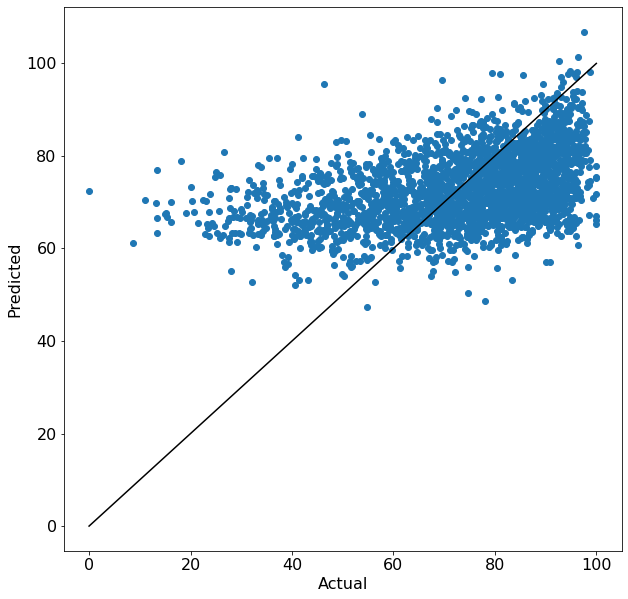

In [ ]:
# Linear Regression
regr = LinearRegression()
regr.fit(X_train, y_train)
pred = regr.predict(X_test)
print("Linear Regression")
print("Mean Squared Error: " + str(metrics.mean_squared_error(y_test, pred)))
print("Mean Absolute Error: " + str(metrics.mean_absolute_error(y_test, pred)))

fig, axes = plt.subplots(figsize=(10,10))
axes.scatter(y_test, pred)
axes.set_xlabel('Actual')
axes.set_ylabel('Predicted')
axes.plot([0, 100], [0,100], c='k');

SVM
Mean Squared Error: 267.6251941961098
Mean Absolute Error: 12.528353170525158


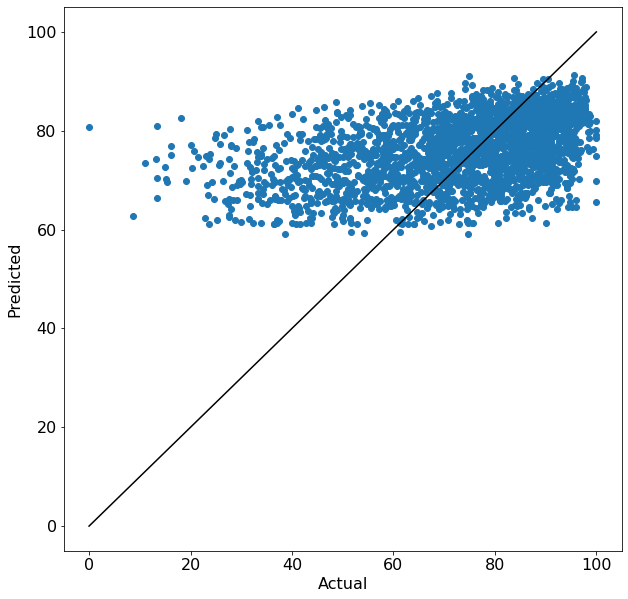

In [ ]:
# Support Vector Machine
svm = SVR()
svm.fit(X_train, y_train)
pred = svm.predict(X_test)
print("SVM")
print("Mean Squared Error: " + str(metrics.mean_squared_error(y_test, pred)))
print("Mean Absolute Error: " + str(metrics.mean_absolute_error(y_test, pred)))

fig, axes = plt.subplots(figsize=(10,10))
axes.scatter(y_test, pred) 
axes.set_xlabel('Actual')
axes.set_ylabel('Predicted')
axes.plot([0, 100], [0,100], c='k');

Random Forest
Mean Squared Error: 252.17516654384184
Mean Absolute Error: 12.355474191133636
Predictions: 72.76709276826121 ± 9.976017577772108
Actual: 73.10726798117321 ± 17.661067601607705


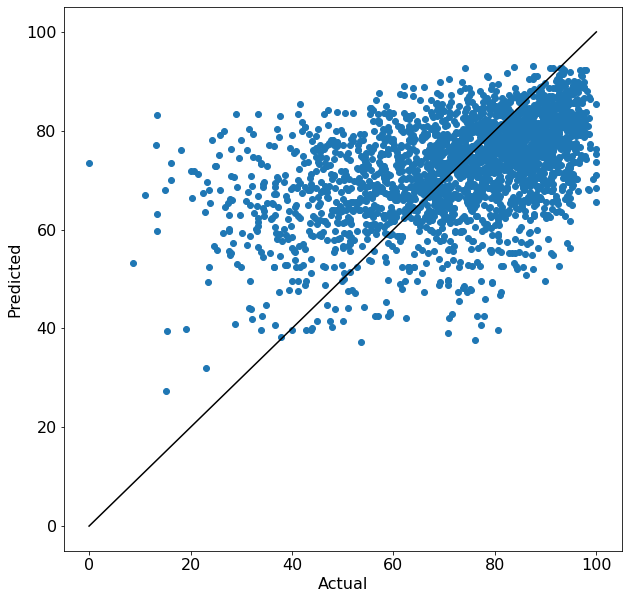

In [ ]:
# Random Forest
rf = RandomForestRegressor(n_estimators=100, bootstrap = True, max_features = 'sqrt')
rf.fit(X_train, y_train)
pred = rf.predict(X_test)
print("Random Forest")
print("Mean Squared Error: " + str(metrics.mean_squared_error(y_test, pred)))
print("Mean Absolute Error: " + str(metrics.mean_absolute_error(y_test, pred)))
print("Predictions: " + str(pred.mean()) + " ± " + str(pred.std()))
print("Actual: " + str(df['rating'].mean()) + " ± " + str(df['rating'].std()))

fig, axes = plt.subplots(figsize=(10,10))
axes.scatter(y_test, pred)
axes.set_xlabel('Actual')
axes.set_ylabel('Predicted')
axes.plot([0, 100], [0,100], c='k');

### Experiment 3 - Only the best features known at publishing time

Linear Regression
Root Mean Squared Error: 16.66453986391377
Mean Absolute Error: 13.2196022918167

SVM
Root Mean Squared Error: 16.86177925383966
Mean Absolute Error: 13.01704665012471

Random Forest
Root Mean Squared Error: 17.419714557751238
Mean Absolute Error: 13.589424221730566


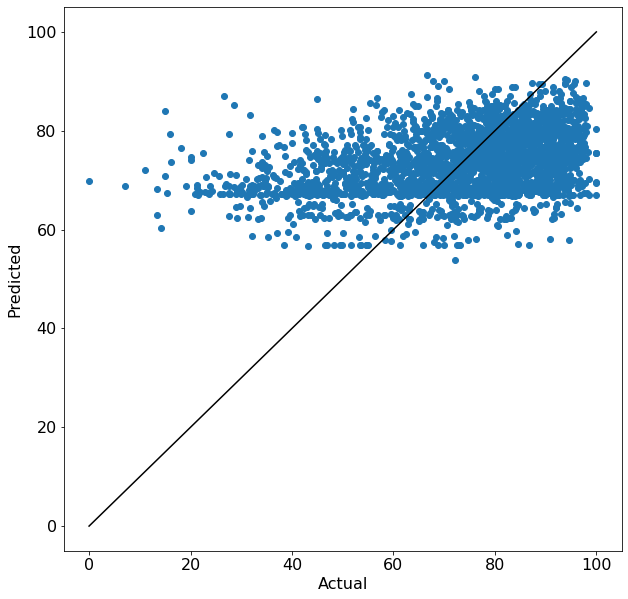

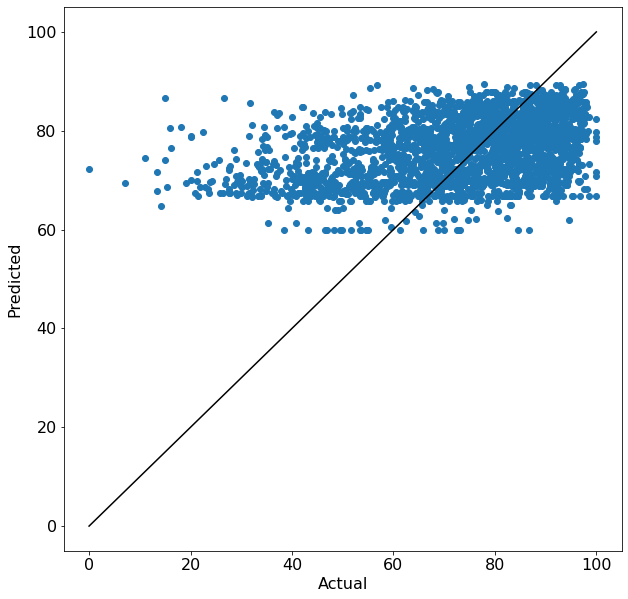

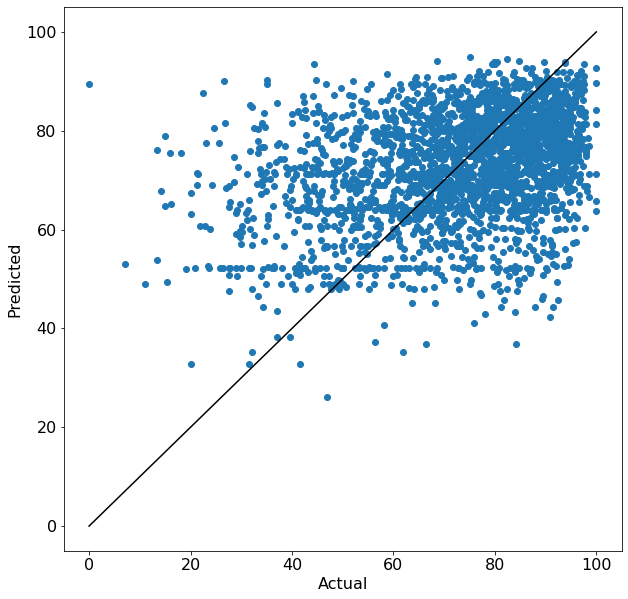

In [ ]:
# will be only categorical variables
pred_df = pd.concat([df[['english', 'achievements', 'price']], platform_df[['platforms:linux', 'platforms:mac']],
                     genre_df[['genres:Simulation', 'genres:Massively Multiplayer']],
                     cat_df[['categories:Full controller support', 'categories:Steam Cloud', 'categories:Steam Achievements']],
                     tag_df[['steamspy_tags:Simulation', 'steamspy_tags:Massively Multiplayer','steamspy_tags:Local Multiplayer', 'steamspy_tags:Puzzle']]], axis=1);

X = pred_df.to_numpy()
Y = df["rating"]
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.30)

# Linear Regression
regr = LinearRegression()
regr.fit(X_train, y_train)
pred = regr.predict(X_test)
print("Linear Regression")
print("Root Mean Squared Error: " + str(metrics.mean_squared_error(y_test, pred, squared=False)))
print("Mean Absolute Error: " + str(metrics.mean_absolute_error(y_test, pred)) + "\n")

fig, axes = plt.subplots(figsize=(10,10))
axes.scatter(y_test, pred)
axes.set_xlabel('Actual')
axes.set_ylabel('Predicted')
axes.plot([0, 100], [0,100], c='k');

# Support Vector Machine 
svm = SVR()
svm.fit(X_train, y_train)
pred = svm.predict(X_test)
print("SVM")
print("Root Mean Squared Error: " + str(metrics.mean_squared_error(y_test, pred, squared=False)))
print("Mean Absolute Error: " + str(metrics.mean_absolute_error(y_test, pred)) + "\n")

fig, axes = plt.subplots(figsize=(10,10))
axes.scatter(y_test, pred)
axes.set_xlabel('Actual')
axes.set_ylabel('Predicted')
axes.plot([0, 100], [0,100], c='k');

# Random Forest
rf = RandomForestRegressor(n_estimators=100, bootstrap = True, max_features = 'sqrt')
rf.fit(X_train, y_train)
pred = rf.predict(X_test)
print("Random Forest")
print("Root Mean Squared Error: " + str(metrics.mean_squared_error(y_test, pred, squared=False)))
print("Mean Absolute Error: " + str(metrics.mean_absolute_error(y_test, pred)))

fig, axes = plt.subplots(figsize=(10,10))
axes.scatter(y_test, pred)
axes.set_xlabel('Actual')
axes.set_ylabel('Predicted')
axes.plot([0, 100], [0,100], c='k');